<a href="https://colab.research.google.com/github/BloodyUnicorn/Application-identification/blob/main/CNN_Traffic_Identification_for_3_Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [78]:
!pip install scapy

In [79]:
from pathlib import Path
import os
import os.path
from google.colab import drive
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scapy.compat import raw
from scapy.layers.inet import IP, UDP
from scapy.layers.l2 import Ether
from scapy.packet import Padding
from scapy.utils import rdpcap, PcapReader
from scipy import sparse
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

from scapy.layers.dns import DNS
from scapy.layers.inet import TCP
from scapy.packet import Padding
from scapy.utils import rdpcap

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from random import sample
import matplotlib.pyplot as plt
import seaborn as sn
import math
import random


from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn import functional as F

import time
from datetime import timedelta
from datetime import datetime
import pickle
import random
from prettytable import PrettyTable

In [80]:
## Colab setting
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
[Errno 2] No such file or directory: 'gdrive/MyDrive/'
/content/gdrive/MyDrive


In [81]:
# Call `set_seed` function in the exercises to ensure reproducibility.

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)


In [82]:
SEED = 2021
set_seed(seed=SEED)

Random seed 2021 has been set.


In [83]:
def remove_ether_header(packet):
    if Ether in packet:
        return packet[Ether].payload

    return packet


def mask_ip(packet):
    if IP in packet:
        packet[IP].src = '0.0.0.0'
        packet[IP].dst = '0.0.0.0'

    return packet


def pad_udp(packet):
    if UDP in packet:
        # get layers after udp
        layer_after = packet[UDP].payload.copy()

        # build a padding layer
        pad = Padding()
        pad.load = '\x00' * 12

        layer_before = packet.copy()
        layer_before[UDP].remove_payload()
        packet = layer_before / pad / layer_after

        return packet

    return packet


def packet_to_sparse_array(packet, max_length=1500):
    arr = np.frombuffer(raw(packet), dtype=np.uint8)[0: max_length]     # Divide to 255 later
    if len(arr) < max_length:
        pad_width = max_length - len(arr)
        arr = np.pad(arr, pad_width=(0, pad_width), constant_values=0)

    arr = sparse.csr_matrix(arr)
    return arr


def should_omit_packet(packet):
    # SYN, ACK or FIN flags set to 1 and no payload
    if TCP in packet and (packet.flags & 0x13):
        # not payload or contains only padding
        layers = packet[TCP].payload.layers()
        if not layers or (Padding in layers and len(layers) == 1):
            return True

    # DNS segment
    if DNS in packet:
        return True

    return False


def transform_packet(packet):
    if should_omit_packet(packet):
        return None

    packet = remove_ether_header(packet)
    packet = pad_udp(packet)
    packet = mask_ip(packet)

    arr = packet_to_sparse_array(packet)

    return arr

In [84]:
# for app identification
PREFIX_TO_APP_ID = {
    # Aparat
    'aparat': 0,
    # # Filimo
    'filimo': 1,
    # Digikala
    'digikala1': 2,
}

ID_TO_APP = {
    0: 'Aparat',
    1: 'Filimo',
    2 : 'Digikala',
}



In [85]:
pcaps = 'Created_Dataset/DFA_pcaps/'
if not os.path.exists(os.path.dirname(pcaps)):
   os.makedirs(os.path.dirname(pcaps))

In [86]:
cache = 'Created_Dataset/Dataset_3classes/dataset.pickle'
if not os.path.exists(os.path.dirname(cache)):
   os.makedirs(os.path.dirname(cache))
dataset = []

In [87]:
if not os.path.isfile(cache):
    for path in os.listdir(pcaps):
        print('Processing ' + path)
        for i, packet in enumerate(rdpcap(pcaps + path)):
            arr = transform_packet(packet)
            if arr is not None:
                # get labels for app identification
                prefix = path.split('.')[0].lower()
                app_label = PREFIX_TO_APP_ID.get(prefix)
                row = {
                    'app_label': app_label,
                    'feature': arr.todense().tolist()[0]
                }
                dataset.append(row)
    
    with open(cache, 'wb') as f:
        pickle.dump(dataset, f)
else:
    dataset = []
    # data_dir = 'drive/MyDrive/deep_packet/Dataset/'
    # for path in os.listdir(data_dir):
    #     with open(data_dir + path, 'rb') as f:
    #         dataset.extend(pickle.load(f))
    with (open(cache, "rb")) as f:
        dataset.extend(pickle.load(f))
        

# pprint(dataset)

In [88]:
# from pprint import pprint
# objects = []
# data_dir = 'drive/MyDrive/Created_dataset/Dataset/'
# with (open(cache, "rb")) as openfile:
#     while True:
#         try:
#             objects.append(pickle.load(openfile))
#         except EOFError:
#             break
        
# pprint(objects)

In [89]:
app_labels = [row['app_label'] for row in dataset]
app_classes = set(app_labels)
app_train_all, app_test_all = train_test_split(dataset, test_size=0.2, random_state=42, stratify=app_labels)

del dataset

In [90]:
app_train_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in elem['feature']], dtype=np.float32)), 'label': elem['app_label']} for elem in app_train_all]
del app_train_all
app_test_final = [{'feature': torch.from_numpy(np.array([a/255.0 for a in elem['feature']], dtype=np.float32)), 'label': elem['app_label']} for elem in app_test_all]
del app_test_all

In [91]:
print(type(app_train_final))
print(len(app_train_final))

<class 'list'>
31643


In [92]:
batch_size = 64
num_workers = 2

app_train_loader = torch.utils.data.DataLoader(app_train_final, batch_size=batch_size, num_workers=num_workers)
app_test_loader = torch.utils.data.DataLoader(app_test_final, batch_size=batch_size, num_workers=num_workers)

## CNN Model

In [103]:
class ConvNet(nn.Module):
  def __init__(self):
      super(ConvNet,self).__init__()
      

      self.conv1 = nn.Sequential( 
                        nn.Conv1d(
                            in_channels=1,
                            out_channels=150,
                            kernel_size=5, 
                            stride=3, 
                            padding = 0) 
                        
                        ,nn.ReLU()
      )
      
    

      self.maxpool = nn.MaxPool1d(2)

      # use a dummy input to calculate
      random_input = torch.rand(1, 1, 1500 , requires_grad=False)
      random_input = self.conv1(random_input)
      random_input = self.maxpool(random_input)
      maxpool_out = random_input.view(1, -1).shape[1]

      self.fc1 = nn.Sequential(
            nn.Linear(
                in_features= maxpool_out,
                out_features=100
            ),
            nn.Dropout(p=0.05),
            nn.ReLU()
        )
      

      self.fc2 = nn.Sequential(
            nn.Linear(
                in_features=100,
                out_features=50
            ),
            nn.Dropout(p=0.05),
            nn.ReLU()
        )


      self.fc3 = nn.Sequential(
            nn.Linear(
                in_features=50,
                out_features=25
            ),
            nn.Dropout(p=0.05),
            nn.ReLU()
        )
   
      
      self.lastlayer = nn.Linear(
            in_features=25,
            out_features=3
        )
  def forward(self,x):

      #adding 1 dimention
      x = x.unsqueeze(1)

      #conv layers
      x = self.conv1(x)
      x = self.maxpool(x)

      #flatten
      x = x.reshape(x.shape[0], -1)

      #3fc
      x = self.fc1(x)
      x = self.fc2(x)
      x = self.fc3(x)

      #output
      x = self.lastlayer(x)

      return x

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Train and Test

In [105]:
def Training(model, train_loader, criterion, optimizer, epochs):

  train_losses  = [] 
  Acc =[]

  for epoch in range(epochs):

      epoch_accuracy =  0
      total_correct = 0
      train_loss = 0
      total_pcaps = 0

      model.train()
      for elem in train_loader:

          pcap_byte = elem['feature'].to(device)
          

          labels = elem['label'].to(device)
          
          
          # Clear gradients w.r.t. parameters
          optimizer.zero_grad()

          # Forward pass to get output/logits
          outputs = model(pcap_byte)

          # Calculate Loss
          loss = criterion(outputs, labels)

          # Getting gradients w.r.t. parameters
          loss.backward()

          # Updating parameters
          optimizer.step()
          
          total_pcaps += labels.size(0)

          # Obtaining predictions from max value
          _, predicted = torch.max(outputs.data, 1)


          # Calculate the number of correct answers
          correct = (predicted == labels).sum().item()

          train_loss += loss.item()
          total_correct += correct

      epoch_accuracy = ((total_correct / total_pcaps) * 100)
      Acc.append(epoch_accuracy)
      average_loss = train_loss / len(train_loader)
      train_losses.append(train_loss)
      print('epoch %d, train_loss: %.3f' % (epoch + 1, average_loss))
      


  Accuracy = ((total_correct / total_pcaps) * 100)
  print('Training Accuracy: %.3f' % (Accuracy))
  plt.plot(np.arange(len(train_losses)), train_losses, 'r')
  plt.xlabel('Epoch')
  plt.ylabel('Train Loss')
  plt.show()
  

  plt.plot(np.arange(len(Acc)), Acc, 'b')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.show()

In [106]:
model = ConvNet().to(device)
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate ) 
criterion = nn.CrossEntropyLoss()
print(model)

ConvNet(
  (conv1): Sequential(
    (0): Conv1d(1, 150, kernel_size=(5,), stride=(3,))
    (1): ReLU()
  )
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Sequential(
    (0): Linear(in_features=37350, out_features=100, bias=True)
    (1): Dropout(p=0.05, inplace=False)
    (2): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): Dropout(p=0.05, inplace=False)
    (2): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=50, out_features=25, bias=True)
    (1): Dropout(p=0.05, inplace=False)
    (2): ReLU()
  )
  (lastlayer): Linear(in_features=25, out_features=3, bias=True)
)


## Iterations

epoch 1, train_loss: 1.025
epoch 2, train_loss: 1.010
epoch 3, train_loss: 1.007
epoch 4, train_loss: 1.005
epoch 5, train_loss: 1.003
epoch 6, train_loss: 1.000
epoch 7, train_loss: 0.998
epoch 8, train_loss: 0.995
epoch 9, train_loss: 0.992
epoch 10, train_loss: 0.989
epoch 11, train_loss: 0.986
epoch 12, train_loss: 0.981
epoch 13, train_loss: 0.977
epoch 14, train_loss: 0.971
epoch 15, train_loss: 0.962
epoch 16, train_loss: 0.954
epoch 17, train_loss: 0.942
epoch 18, train_loss: 0.929
epoch 19, train_loss: 0.913
epoch 20, train_loss: 0.894
epoch 21, train_loss: 0.872
epoch 22, train_loss: 0.848
epoch 23, train_loss: 0.825
epoch 24, train_loss: 0.805
epoch 25, train_loss: 0.784
epoch 26, train_loss: 0.766
epoch 27, train_loss: 0.750
epoch 28, train_loss: 0.739
epoch 29, train_loss: 0.727
epoch 30, train_loss: 0.714
epoch 31, train_loss: 0.697
epoch 32, train_loss: 0.684
epoch 33, train_loss: 0.670
epoch 34, train_loss: 0.654
epoch 35, train_loss: 0.636
epoch 36, train_loss: 0.614
e

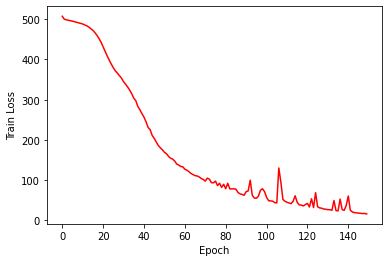

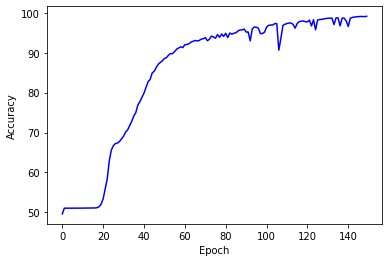

In [107]:
Training(model,app_train_loader,criterion,optimizer,150)

In [108]:
def test_model_accuracy(model, test_loader, classes):
    # Calculate Accuracy         
    correct = 0.
    total = 0.
    correct_predicted = {id : 0 for id in range(len(classes))}
    num_of_labels = {id : 0 for id in range(len(classes))}
    all_predicted = {id : 0 for id in range(len(classes))}
    confusion = [ [0] * len(classes) for _ in range(len(classes))]

    # Iterate through test dataset
    with torch.no_grad():
      for elem in test_loader:
        byte_array = elem['feature'].to(device)
        labels = elem['label']
        outputs = model(byte_array)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        for p, l in zip(predicted, labels):
            num_of_labels[l.item()] += 1
            pc = p.to('cpu').item()
            all_predicted[pc] += 1
            confusion[l][pc] += 1

            if p == l:
                correct_predicted[pc] += 1

        correct += (predicted.to('cpu') == labels).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy: {}%'.format(accuracy))
    return confusion, [x / y if y else 0 for x, y in zip(correct_predicted.values(), all_predicted.values())], [x / y if y else 0 for x, y in zip(correct_predicted.values(), num_of_labels.values())]

In [109]:
def analyse(model, train_loader, test_loader, classes, task):
    # print('Train ', end='')
    _, train_rcs, train_prs = test_model_accuracy(model, train_loader, classes)
    print('Test ', end='')
    confusion, test_rcs, test_prs = test_model_accuracy(model, test_loader, classes)
    test_f1 = []
    table = PrettyTable(['Class', 'Rc', 'Pr', 'F1'])

    for i, (rc, pr) in enumerate(zip(test_rcs, test_prs)):
        f1 = 2 * rc * pr / (rc + pr) if (rc + pr) else 0
        test_f1.append(f1)
        class_name = ID_TO_APP.get(classes[i])
        table.add_row([class_name, str(round(rc, 3)), str(round(pr, 3)), str(round(f1, 3))])

    np_rcs = np.array(test_rcs)
    rc_avg = np_rcs[np.nonzero(np_rcs)].mean()
    np_prs = np.array(test_prs)
    pr_avg = np_prs[np.nonzero(np_prs)].mean()
    np_f1s = np.array(test_f1)
    f1_avg = np_f1s[np.nonzero(np_f1s)].mean()
    table.add_row(['Available Classes Avg', str(round(rc_avg, 3)), str(round(pr_avg, 3)), str(round(f1_avg, 3))])
    print(table)

    class_names = [ID_TO_APP.get(c) for c in classes]
    plt.figure(figsize=(30, 9), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar([i - 0.1 for i in range(len(classes))], train_prs, width=0.2, label='Train')
    plt.bar([i + 0.1 for i in range(len(classes))], test_prs, width=0.2, label='Test')
    plt.legend()
    plt.xlim(-0.2, len(classes))
    plt.xticks(list(range(len(classes))), class_names, rotation='vertical')
    plt.title('Comparision Between Test and Train Accuracies')
    plt.xlabel('Category')
    plt.ylabel('Accuracy')
    plt.show()

    df_cm = pd.DataFrame(confusion, index = [i for i in class_names], columns = [i for i in class_names])
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True)

In [110]:
app_labels = []
for i in sorted(list(ID_TO_APP.keys())):
    app_labels.append(ID_TO_APP[i])

print(app_labels)

['Aparat', 'Filimo', 'Digikala']


In [111]:
correct = 0.
total = 0.
model.eval()
with torch.no_grad():
      for elem in app_test_loader:
        byte_array = elem['feature'].to(device)
        labels = elem['label'].to(device)
        outputs = model(byte_array)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print('Accuracy: {}%'.format(accuracy))

Accuracy: 97.01681203387687%


Accuracy: 99.38058970388396%
Test Accuracy: 97.01681203387687%
+-----------------------+-------+-------+-------+
|         Class         |   Rc  |   Pr  |   F1  |
+-----------------------+-------+-------+-------+
|         Aparat        | 0.962 |  0.97 | 0.966 |
|         Filimo        |  0.96 | 0.975 | 0.967 |
|        Digikala       | 0.979 | 0.968 | 0.973 |
| Available Classes Avg | 0.967 | 0.971 | 0.969 |
+-----------------------+-------+-------+-------+


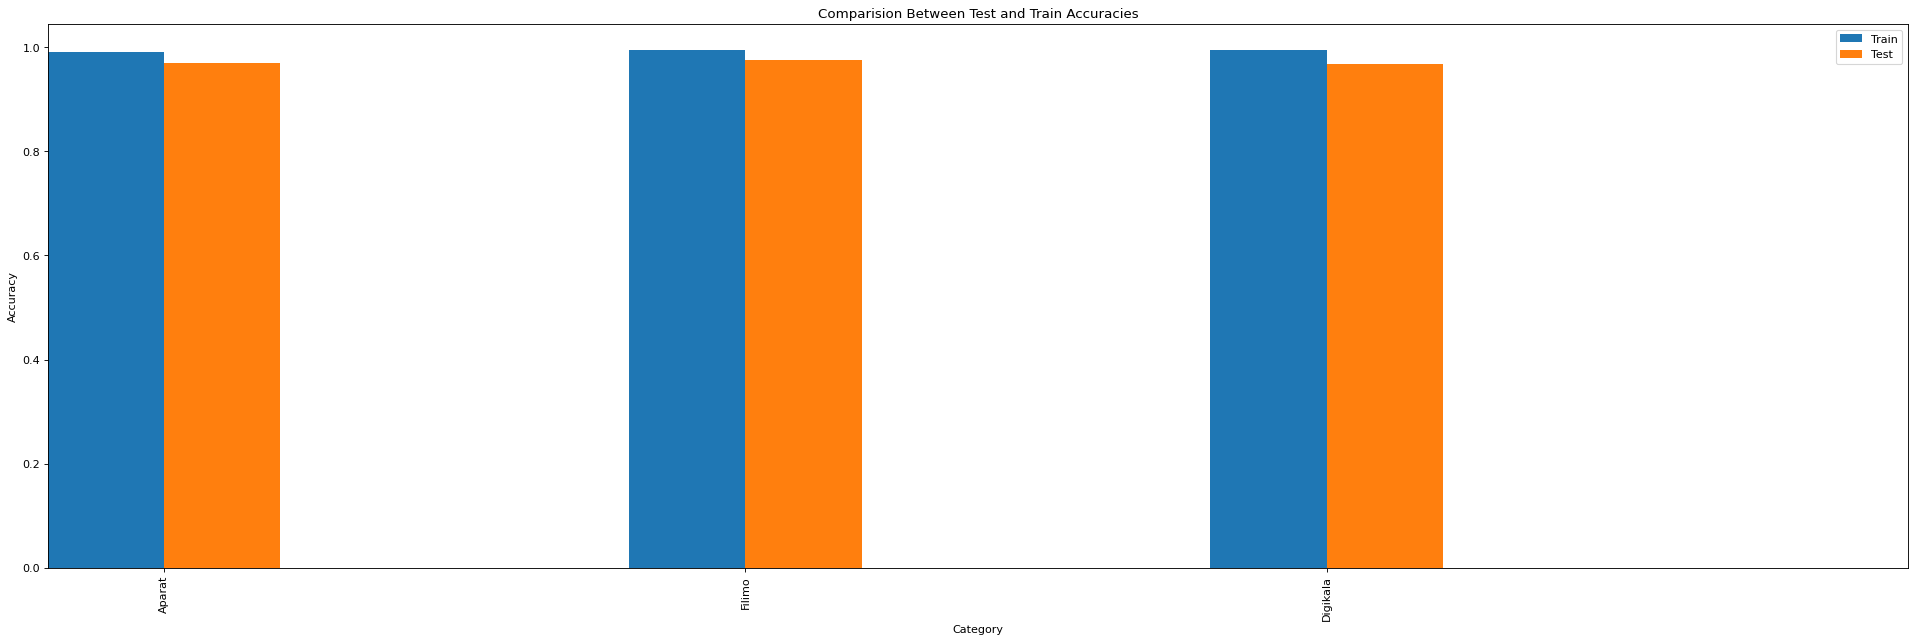

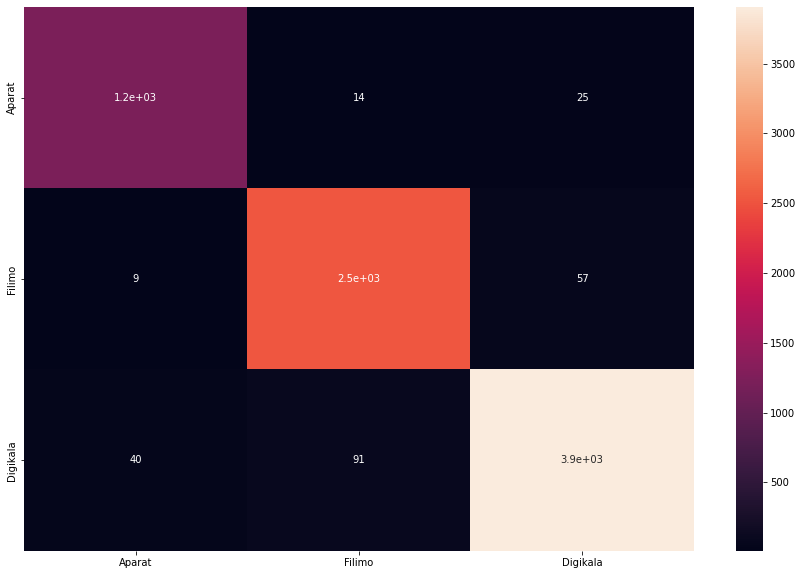

In [112]:
all_app_classes = [i for i in range(max(app_classes) + 1)]
analyse(model, app_train_loader, app_test_loader, all_app_classes, 'app')